# Computer Vision 2020

---

## Exercise Sheet 2

**Due: 19. November 2020, 2pm**

## Tim Ansink 5630190

**Acknowledgement**: Parts of this exercise are adapted from [Stanford CS231n](http://cs231n.stanford.edu/).

## 1 Introduction

In this exercise you'll implement the k-Nearest Neighbor algorithm and cross validation as a means to select a suitable value for $k$. You will also implement a preprocessing step to see how this affects accuracy of the model.

## 2 Setup

### 2.1 Import NumPy, OpenCV and other helpers

Besides NumPy and OpenCV we're also going to use a utility function to load the dataset we want to work with.

In [1]:
import cv2
import numpy as np

from data_utils import load_CIFAR10

### 2.2 Load and configure Matplotlib for use in Jupyter notebook

We want Matplotlib figures to appear within the notebook rather than inside a separate window, so we make use of the `%matplotlib` magic function to set the [Matplotlib backend](https://matplotlib.org/tutorials/introductory/usage.html#backends) to `inline`. This way the figure appears right after the cell where the [show](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.show.html?highlight=show#matplotlib.pyplot.show) method has been called.

In [2]:
%matplotlib inline

import matplotlib
from   matplotlib import pyplot as plt

In [3]:
# Set default size of plots.
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# Set default color map and interpolation method for images.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

### 2.3 Enable auto reload of exernal modules

The following lines configure IPython to automatically reload external modules if they've been changed.

In [4]:
%load_ext autoreload
%autoreload 2

### 2.5 Load the CIFAR-10 dataset

Lastly we're loading the dataset we want to work with. Keep in mind that the dataset **must not** be part of the files that you upload when handing in your solutions!

In [5]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_CIFAR10('datasets/cifar-10-batches-py')

# As a sanity check, we output the size of the training and test data.
print(
    f'Training data shape: {X_train.shape}',
    f'Training labels shape: {y_train.shape}',
    f'Test data shape: {X_test.shape}',
    f'Test labels shape: {y_test.shape}',

    sep = '\n'
)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


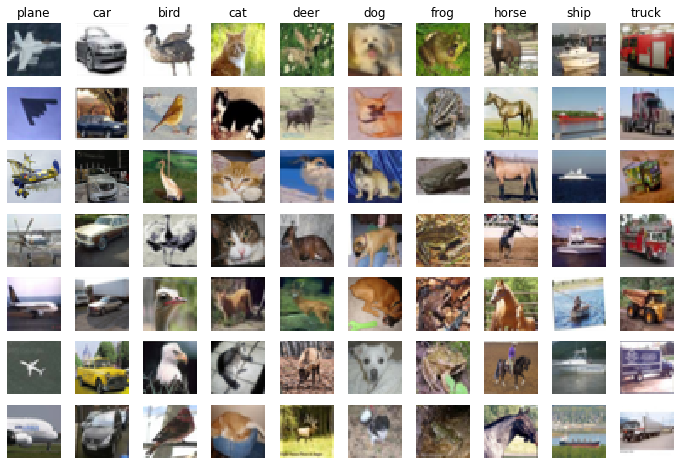

In [6]:
# Visualize some examples from the dataset.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
samples_per_class = 7


for y, cls in enumerate(classes):

    # Get selection of indices of images with the current label.
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace = False)

    for i, idx in enumerate(idxs):

        # Calculate index for figure and create subplot.
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)

        # Show image at selected index.
        plt.imshow(X_train[idx].astype(np.uint8))
        plt.axis('off')

        if i == 0:
            plt.title(cls)


# Display the images.
plt.show()

## 3 Exercises

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it.
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the $k$ most similar training examples.

The value of $k$ is cross-validated.

### 3.1 Preparation

To reduce the time for code execution in this exercise we subsample the training and test data.

In [7]:
# Use 5000 examples for training.
num_training = 5000
mask = range(num_training)

X_train = X_train[mask]
y_train = y_train[mask]

# Use 500 examples for testing.
num_test = 500
mask = range(num_test)

X_test = X_test[mask]
y_test = y_test[mask]

In kNN the images are treated as vectors in a high dimensional vector space.

#### Exercise (5P)

Implement a function that takes a set of images shaped like the training and test data loaded above and transforms each image into a vector. Fill your code in the function definition below.

#### Solution

In [28]:
def vectorize(data):
    """Transform images into vectors."""
    ################################################################################
    #                             START OF YOUR CODE                               #
    ################################################################################
    imgCount, x, y, z = data.shape
    out = np.zeros_like(data).reshape((imgCount, x*y*z))
    
    for i in range(imgCount):
        out[i] = data[i].flatten()
    
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    return out

Let's transform the samples for training and testing.

In [29]:
# Transform training and test images into vectors.
X_train_v = vectorize(X_train)
X_test_v  = vectorize(X_test)

### 3.2 Distances

To find the nearest neighbors of an image, we need a distance function.  
In this exercise we're going to use two metrics, the Manhattan distance induced by the $L^1$ norm and the Euclidean distance induced by the $L^2$ norm.

Let $v, w \in \mathbb{R}^n$ be real vectors. Then the Manhatten distance between $v$ and $w$ is defined as

$$
    \mathrm{d}_1(v, w) = \left\Vert v - w \right\Vert_1 = \sum_{i = 1}^n \lvert v_i - w_i \rvert.
$$

The Euclidean distance between $v$ and $w$ is defined as

$$
    \mathrm{d}_2(v, w) = \left\Vert v - w \right\Vert_2 = \sqrt{\sum_{i = 1}^n (v_i - w_i)^2}.
$$

#### Exercise (10P)

Implement a function that computes a distance matrix for two datasets using the *Manhattan distance*. Fill your code in the function definition below.

#### Solution

In [45]:
def d1(V, W):
    """
    Compute the Manhattan distances between all points in datasets V and W.
    The distance matrix has |V| times |W| elements.
    """
    ################################################################################
    #                             START OF YOUR CODE                               #
    ################################################################################
    
    dists = np.zeros((len(V), len(W)))
    
    for i in range(len(V)):
        for j in range(len(W)):
            dists[i, j] = abs(V[i] - W[j]).sum()

    print(dists)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    return dists

[[-34737588. -44237120. -44182954. ... -39522642. -50411575. -26520011.]
 [-46941465. -64260444. -76213582. ... -60939591. -73274774. -30872739.]
 [-40528662. -56273326. -64414557. ... -52664441. -61482880. -28021242.]
 ...
 [-44139525. -56854334. -55662662. ... -50981428. -65520804. -35039794.]
 [-37332586. -47758866. -49685744. ... -43455995. -56283242. -28205907.]
 [-63938164. -80788787. -85437181. ... -75241334. -96917040. -49863184.]]
[[167664. 188615. 240781. ... 179399. 196712. 202970.]
 [299995. 242668. 178870. ... 224700. 217865. 385475.]
 [237506. 188165. 168501. ... 171101. 204114. 296450.]
 ...
 [241463. 229618. 307496. ... 238764. 214037. 268735.]
 [161986. 171691. 229345. ... 164213. 140094. 210722.]
 [356015. 293736. 302686. ... 289506. 190133. 401109.]]


array([[167664., 188615., 240781., ..., 179399., 196712., 202970.],
       [299995., 242668., 178870., ..., 224700., 217865., 385475.],
       [237506., 188165., 168501., ..., 171101., 204114., 296450.],
       ...,
       [241463., 229618., 307496., ..., 238764., 214037., 268735.],
       [161986., 171691., 229345., ..., 164213., 140094., 210722.],
       [356015., 293736., 302686., ..., 289506., 190133., 401109.]])

#### Exercise (20P)

Implement a function that computes a distance matrix for two datasets using the *Euclidean distance*. The function should be fully vectorized, so don't use loops. Fill your code in the function definition below.

**Hint**: Try to transform the formula for the Euclidean distance so that you can use matrix multiplication.

#### Solution

In [78]:
def d2(V, W):
    """
    Compute the Eucledian distances between all points in datasets V and W.
    The distance matrix has |V| times |W| elements.
    """
    ################################################################################
    #                             START OF YOUR CODE                               #
    ################################################################################
    #transformedEuclidean = -2 * np.matmul(V, W.transpose()) + V ** 2 + W ** 2
    #print(transformedEuclidean)
    
    # Parts are not necessary, only for testing. One line would have been enough.
    squaredW = np.sum(W**2, axis=1)
    squaredV = np.sum(V**2, axis=1)[:, np.newaxis]

    dists = np.sqrt(-2 * np.dot(V, W.T) + squaredW + squaredV)

    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    return dists

### 3.3 Predicting Labels

Given a distance matrix, we have to find the $k$ nearest neighbors for each data point in our test set and make them vote for the label that we should assign.

#### Exercise (30P)

Implement a function that predicts labels based on the $k$ nearest neighbors for a given test set. If there is more than one most common label, break ties by choosing the larger label. Fill in your code in the definition of the `predict` method below.

#### Solution

In [219]:
class KNN():
    """K nearest neighbor classifier"""


    def train(self, X, y):
        """
        Training only means to store the given training data.
        All computations are deferred to the test phase.
        """
        self.X_train = X
        self.y_train = y


    def predict(self, X, d, k):
        """
        Predict labels for points in a given dataset X, provided
        a function d to compute the distance matrix and using the
        k nearest neighbors.
        """
        import collections

        dists = d(X, self.X_train)

        # Get number of data points in test set.
        num_test, _ = X.shape

        # Create array for predicted labels.
        y_pred = np.zeros(num_test)
        
        neighbor_distances_and_indices = []
        
        for i in range(num_test):
            ################################################################################
            #                             START OF YOUR CODE                               #
            ################################################################################
            
            # Find k nearest neighbors
            minimalValue = np.partition(dists[i], k)[:k]
            minimalIndex = np.argpartition(dists[i], k)[:k]
            kNearestNeighbors = list(zip(minimalValue, minimalIndex))
            
            neighbor_distances_and_indices.append(kNearestNeighbors)
            
            # Choose larger label
            for j in range(len(neighbor_distances_and_indices[i])):
                countLabels = collections.Counter()

                ### You should not access global variables. The y_train array
                ### just happens to be the same as the one stored in the attribute
                ### of the same name, but this could be something else. 27/30

                countLabels[y_train[neighbor_distances_and_indices[i][j][1]]] += 1
                
            
            label = countLabels.most_common(1)[0][0]

            y_pred[i] = label

            ################################################################################
            #                              END OF YOUR CODE                                #
            ################################################################################
        return y_pred

To test your implementation, you can run the following code cells.

In [220]:
# Create instance of kNN classifier.
classifier = KNN()

# Store training data.
classifier.train(X_train_v, y_train)

# Predict labels for test data using Euclidean distance and just the nearest neighbor.
y_pred = classifier.predict(X_test_v, d2, 1)

In [221]:
# Compute and print the fraction of correctly predicted examples.

num_correct = np.sum(y_pred == y_test)

print(f'Got {num_correct} / {num_test} correct => accuracy: {num_correct / num_test}')

Got 137 / 500 correct => accuracy: 0.274


You should expect to see approximately `27%` accuracy.

### 3.4 Cross Validation

To determine which value of $k$ works best for our model we want to perform *cross validation*. So instead of separating out a dedicated validation set from our trainng data to tune this hyperparameter, we select some candidate values and for each one do the following:

- Split the training sample into $n$ partitions of equal size.
- For $i$ from $1 \ldots n$:
  - Select fold $i$ as the validation set and the other $n - 1$ folds as the training set.
  - Evaluate the model with the validation set.
  - Store the accuracy of the predictions.
- Calculate the average accuracy for the current value of $k$.

Finally we select the value of $k$ that performed best and evaluate the model again with this value and the original training and test data.

#### Exercise (25P)

Implement cross validation using the parameters given below. Store the results in the `accuracies` variable such that index $i$ is an array with the accuracies obtained in all rounds for the $i$-th value of $k$. Use the Euclidean distance to compute the distance matrix.

#### Solution

In [ ]:
# Set the parameters to use.
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Split examples into five partitions.
X_train_folds = np.array_split(X_train_v, num_folds)
y_train_folds = np.array_split(y_train,   num_folds)

################################################################################
#                             START OF YOUR CODE                               #
################################################################################

accuracies = []

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

To visualize the results, run the following code.

In [ ]:
# Plot the raw observations collected in the accuracies array.
for i, k in enumerate(k_choices):
    plt.scatter([k] * num_folds, accuracies[i])

# Calculate mean and standard deviation.
accuracies_mean = np.array([ np.mean(v) for v in accuracies ])
accuracies_std  = np.array([ np.std(v)  for v in accuracies ])

# Plot the trend line with error bars that correspond to standard deviation.
plt.errorbar(k_choices, accuracies_mean, yerr = accuracies_std)
plt.title('Cross-validation on k')

# Label the axes.
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')

plt.show()

Based on the results above, we choose the best value for $k$, retrain the classifier using all the training data, and evaluate it on the test data.

In [ ]:
# Choose the k that worked best.
best_k = k_choices[np.argmax(accuracies_mean)]

# Show the value.
print(best_k)

# Store training data.
classifier.train(X_train_v, y_train)

# Predict labels for test data using Euclidean distance and the chosen k.
y_pred = classifier.predict(X_test_v, d2, best_k)

In [ ]:
# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_pred == y_test)

print(f'Got {num_correct} / {num_test} correct => accuracy: {num_correct / num_test}')

### 3.5 Preprocessing

Now we'll see how the results change if we preprocess the image data before we calculate the predictions.

#### Exercise (7P)

Select a filter of your choice to transform the image data into a different feature space before the application of the kNN algorithm. For example, you could extract colors or edges. Observe how this affects the accuracy.

**Hint**: You can use any function from NumPy or OpenCV to implement your solution.

#### Solution

Check your results with the following code.

In [ ]:
# Store training data.
classifier.train(X_train_v, y_train)

# Predict labels for test data using Manhattan distance and the chosen k.
y_pred = classifier.predict(X_test_v, d2, best_k)

In [ ]:
# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_pred == y_test)

print(f'Got {num_correct} / {num_test} correct => accuracy: {num_correct / num_test}')

#### Question (3P)

Did you obtain a better accuracy or are the results worse than those for the unprocessed input data? Give a short explanation about what could be the reason.

#### Answer

*Fill in here*